<h1 align="center"><b>Online Retail II UCI</b></h1>
<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#parameters"><h5>1. Project Parameters</h5></a></li>
    <li><a href="#data"><h5>2. Data Preprocessing</h5></a></li>
    <li><a href="#data"><h5>3. k-means</h5></a></li>
    <li><a href="#data"><h5>4. Hierarchical</h5></a></li>
    <li><a href="#data"><h5>5. Density-based</h5></a></li>
    <li><a href="#data"><h5>6. Results</h5></a></li>
</ul>

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [38]:
# -----------------------------
# 1. Load CSV
# -----------------------------
df = pd.read_csv("./../data/online_retail_II.csv")

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
df = df.dropna(subset=['Customer ID'])

# -----------------------------
# 2. Aggregate per customer
# -----------------------------
df_customer = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',             # number of transactions
    'Quantity': 'sum',                # total items purchased
    'Price': 'mean',                  # average price per item
    'InvoiceDate': lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days  # recency
}).rename(columns={
    'Invoice': 'num_transactions',
    'Quantity': 'total_quantity',
    'Price': 'avg_price',
    'InvoiceDate': 'recency_days'
})

# -----------------------------
# 3. Impute missing values column-wise (if any)
# -----------------------------
col_means = df_customer.mean()
df_customer = df_customer.fillna(col_means)

df_customer.head()

,num_transactions,total_quantity,avg_price,recency_days
Customer ID,,,,
12346.0,12,74285,6.100000,400
12347.0,8,3286,2.546087,402
12348.0,5,2714,3.786275,362
12349.0,4,1624,8.459657,570
12350.0,1,197,3.841176,0


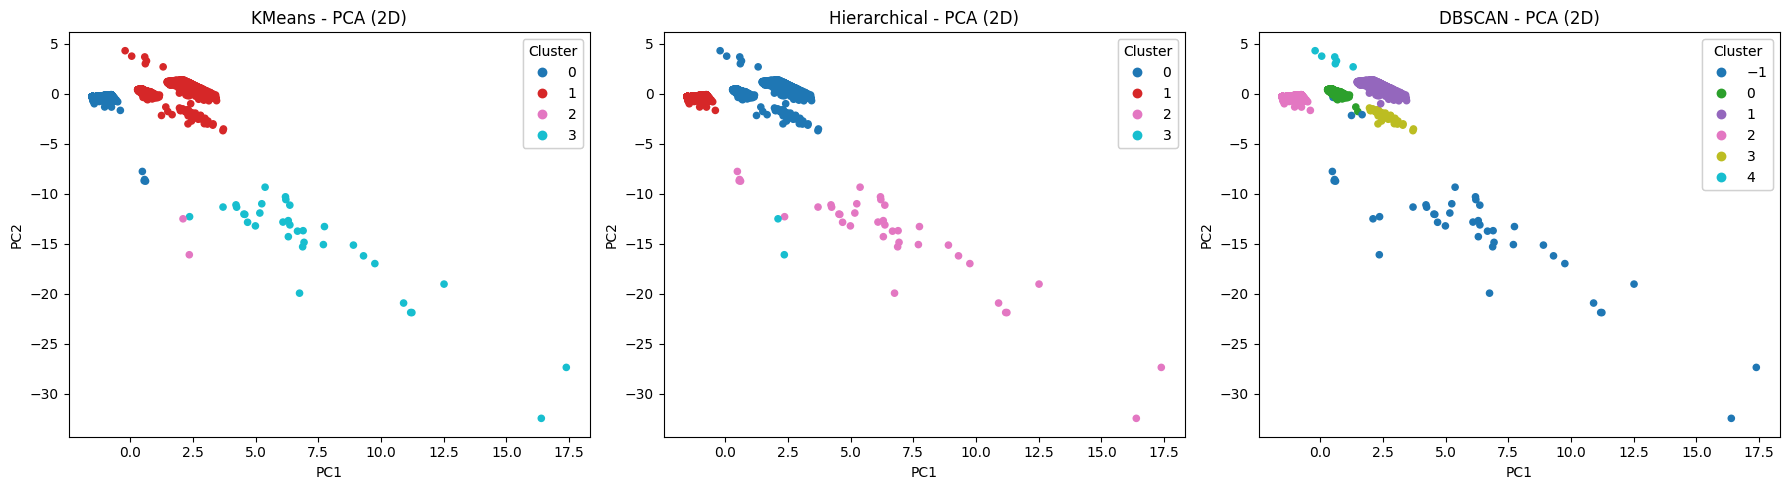

In [40]:
# -----------------------------
# 4. Scale features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_customer)

# -----------------------------
# 5. Define clustering models
# -----------------------------
models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Hierarchical": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5)
}

results = {}

# -----------------------------
# 6. Compute PCA embedding for visualization
# -----------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# -----------------------------
# 7. Clustering + PCA scatter plots
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    start = time.time()
    labels = model.fit_predict(X_scaled)  # clustering on scaled data
    elapsed = time.time() - start

    # Silhouette score only if more than 1 cluster
    if len(set(labels)) > 1 and len(set(labels)) != 1:
        sil = silhouette_score(X_scaled, labels)
    else:
        sil = np.nan

    results[name] = {
        "labels": labels,
        "time": elapsed,
        "silhouette": sil
    }

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=20)
    ax.set_title(f"{name} - PCA (2D)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)

plt.tight_layout()
plt.show()

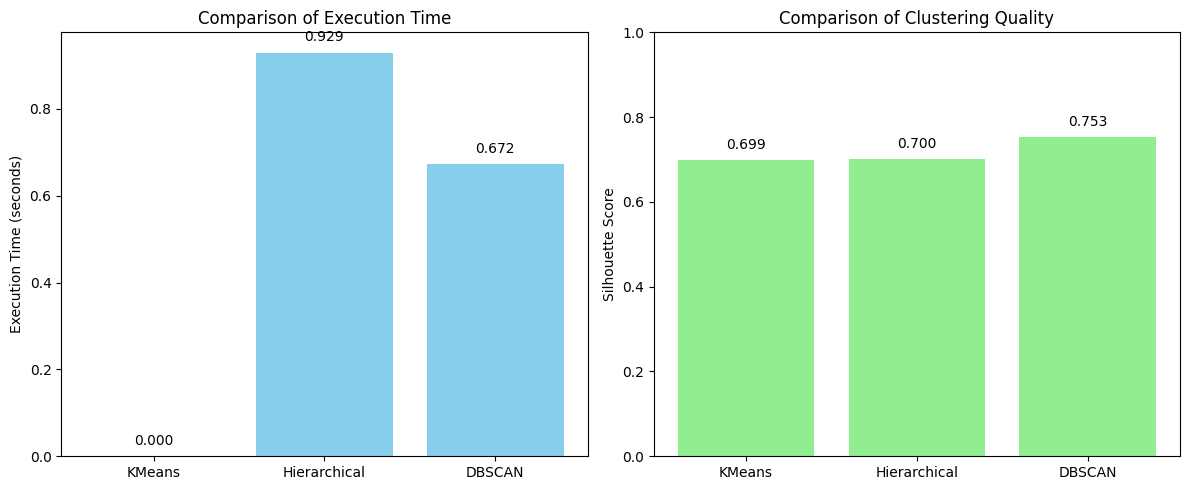

In [43]:
# -----------------------------
# 8. Compare time and silhouette
# -----------------------------
algorithms = list(results.keys())
times = [results[a]['time'] for a in algorithms]
silhouettes = [results[a]['silhouette'] for a in algorithms]

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Execution time
axes[0].bar(algorithms, times, color='skyblue')
axes[0].set_ylabel("Execution Time (seconds)")
axes[0].set_title("Comparison of Execution Time")
for i, v in enumerate(times):
    axes[0].text(i, v + max(times)*0.02, f"{v:.3f}", ha='center', va='bottom')

# Silhouette
axes[1].bar(algorithms, silhouettes, color='lightgreen')
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Comparison of Clustering Quality")
axes[1].set_ylim(0, 1)
for i, v in enumerate(silhouettes):
    axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [41]:
# -----------------------------
# 9. Attach cluster labels to customer dataframe
# -----------------------------
df_customer['KMeans_cluster'] = results['KMeans']['labels']
df_customer['Hierarchical_cluster'] = results['Hierarchical']['labels']
df_customer['DBSCAN_cluster'] = results['DBSCAN']['labels']

print("K-Means")
display(df_customer.groupby('KMeans_cluster').mean())
print("\nHierarchical")
display(df_customer.groupby('Hierarchical_cluster').mean())
print("\nDBSCAN")
display(df_customer.groupby('DBSCAN_cluster').mean())

K-Means


,num_transactions,total_quantity,avg_price,recency_days,Hierarchical_cluster,DBSCAN_cluster
KMeans_cluster,,,,,,
0,2.232759,444.928656,7.087474,71.930737,1.001189,1.996433
1,10.371671,2503.098063,3.414156,541.470541,0.000000,0.762308
2,1.500000,1.500000,8955.835000,0.000000,3.000000,-1.000000
3,110.411765,88433.735294,6.611344,620.205882,2.000000,-1.000000



Hierarchical


,num_transactions,total_quantity,avg_price,recency_days,KMeans_cluster,DBSCAN_cluster
Hierarchical_cluster,,,,,,
0,10.371671,2503.098063,3.414156,541.470541,1.000000,0.762308
1,2.233333,445.456250,5.045472,72.016369,0.000000,2.000000
2,98.973684,79125.105263,187.217431,554.921053,2.684211,-1.000000
3,1.500000,1.500000,8955.835000,0.000000,2.000000,-1.000000



DBSCAN


,num_transactions,total_quantity,avg_price,recency_days,KMeans_cluster,Hierarchical_cluster
DBSCAN_cluster,,,,,,
-1,88.930233,71391.465116,590.070175,506.023256,2.534884,1.906977
0,5.963716,1289.085631,3.168436,379.791001,1.000000,0.000000
1,10.879608,2498.611751,3.331613,601.481567,1.000000,0.000000
2,2.233333,445.456250,5.045472,72.016369,0.000000,1.000000
3,56.409091,14639.522727,3.122952,712.818182,1.000000,0.000000
4,27.166667,44948.666667,1.508595,646.666667,1.000000,0.000000
